## Black Friday Dataset Using Random Forest and Decision Trees
(Data Science Fall 2018)

A retail company “ABC Private Limited” wants to understand the customer purchase behavior (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month. The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

|Variable   | Definition  |
|---|---|---|---|---|
|User_ID|User ID|
|Product_ID|Product ID|
|Gender|Sex of User|
|Age|Age in bins|
|Occupation|Occupation(Masked)|
|City_Category|Category of the City (A,B,C)|
|Stay_In_Current_City_Years|Number of years stay in current city|
|Marital_Status|Marital Status|
|Product_Category_1|Product Category(Masked)|
|Product_Category_2|Product may belong to other category also (Masked)|
|Product_Category_3|Product may belong to other category also (Masked)|
|Purchase|Purchase Amount(Target Variable|

In [1]:
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, learning_curve, validation_curve,RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error

sns.set(style="whitegrid")


During Exploratory Data Analysis (EDA), I found that Product_Category_2 and Product_Category_3 had missing values and per the description of the task(see above), they also seemed to be dependent on Product_Category_1. 

I didn't think it would be a good idea to exclude the observations with missing values since there was still a lot of information that could be gathered from the other variables. Neither did I think filling in the values with the mean, max or zero would be a good idea since it could negatively affect the model. Instead during EDA a feature was created to capture the number of product categories each observation had and which I decided to include in the model.


There were other variables that I didn't think would need to be considered in the model since they were either unique identifiers or were being captured by other variables. From EDA I originally decided to omit the following variables for modeling:

* User_ID: Personal Identifier
* Product_ID: Being captured by Product Categories
* Product_Category_2: It had missing values and is being captured by the feature-engineered categories
* Product_Category_3: It had missing values and is being captured by the feature-engineered categories


After further consideration, I decided to include Product_ID since it showed to improve the model.


I initially started with Random Forest since it is stronger modeling technique and uses several decision trees which helps avoid overfitting. After I decided on a final model, I tried using the Decision Tree learning to compare results and check if the computational load that comes with Random Forest is worthy. 

The final model using Random Forests technique showed: 
$R^2$ = 0.6874
RMSE =  2806.40

The final model for Decision Trees technique showed:
$R^2$ = 0.6815
RMSE =  2832.089620 

Note that Age, City_Category and Stay_In_current_City_Years were encoded and in the model they show as:

City Categories:
* A = 0 
* B = 1
* c = 2

Age:

* 55+ 6
* 51_55 5
* 46_50 4
* 36_45 3
* 26_35 2
* 17-25 1
* 0_17 0

Gender
* F 0
* M 1

Also, EDA graphs were not helpful on trying to find a relationship or gain insights, so I won't be adding any of this information to this notebook. However, if you are curious you can find them in this same repository under the notebook: Black Friday EDA

In [2]:
data=pd.read_csv('blackFriday.csv')

The code below is from the new feature created to find the number of categories a product belongs to:

In [3]:
def categoryNum(df):
    if not math.isnan(df['Product_Category_1']) and not math.isnan(df['Product_Category_2']) and not math.isnan(df['Product_Category_3']):
        return 3
    elif not math.isnan(df['Product_Category_1']) and not math.isnan(df['Product_Category_2']) and math.isnan(df['Product_Category_3']):
        return 2
    elif not math.isnan(df['Product_Category_1']) and math.isnan(df['Product_Category_2']) and not math.isnan(df['Product_Category_3']):
        return 2
    elif not math.isnan(df['Product_Category_1']) and math.isnan(df['Product_Category_2']) and math.isnan(df['Product_Category_3']):
        return 1

In [4]:
data["categories"] = data.apply(categoryNum, axis=1)
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,categories
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,1
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,3
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,1
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,2
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,1


##### Label encoding

I opted for Label Encoding instead of one-hot encoding to have less features 

In [5]:
le = LabelEncoder()
data['Gender_Code']=le.fit_transform(data['Gender'])
data["Age_Code"]=le.fit_transform(data['Age'])
data["City_Code"] = le.fit_transform(data['City_Category'])

data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,categories,Gender_Code,Age_Code,City_Code
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,1,0,0,0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,3,0,0,0
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,1,0,0,0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,2,0,0,0
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,1,1,6,2


Below are the results of the encoding for the different values:

City Categories:
* A = 0 
* B = 1
* c = 2

Age:

* 55+ 6
* 51_55 5
* 46_50 4
* 36_45 3
* 26_35 2
* 17-25 1
* 0_17 0

Gender
* F 0
* M 1

For hyperparameters tuning I used RandomizedSearchCV to get an idea what the best parameters should look like and then used validation curves as an attempt to get a more precise approximation of the parameters.

Setting training and validation sets

In [6]:
train, test = train_test_split(data, test_size = 0.2)

x_train = train.drop(['User_ID', 'Product_ID', 'Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y_train = train['Purchase']

x_test = test.drop(['User_ID', 'Product_ID', 'Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y_test = test['Purchase']

#### RandomSearchCV

Below are the set of hyperparameters used

In [7]:
n_estimators = np.arange(200, 1200, 100)
max_features = ['auto', 'log2']
max_depth = np.arange(1, 21, 1)
min_samples_leaf=np.arange(1, 11, 1)
min_samples_split = np.arange(2,11, 1)
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
              'max_features' : max_features,
              'max_depth' : max_depth,
              'min_samples_leaf' : min_samples_leaf,
              'min_samples_split' : min_samples_split,
              'bootstrap' : bootstrap}

In [8]:
#The following code was used to get the results from RandomSearchCV, remove hash character to run:

#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose = 2, random_state = 48, n_jobs = -1)
#rf_random.fit(x_train, y_train)

In [9]:
#rf_random.best_params_

RandomSearchCV is computational heavy so I only run it once and here are the results when calling rf_random.best_params:

{'n_estimators': 600,
 'min_samples_split': 9,
 'min_samples_leaf': 7,
 'max_features': 'auto',
 'max_depth': 15,
 'bootstrap': True}

I created a base model and compared it to the results from RandomSearchCV and this is what I got

In [10]:
#n_estimators = default, max depth -> reccomend=15
base_model = RandomForestRegressor(max_depth = 15, random_state = 48)
base_model.fit(x_train, y_train)
y_pred_test_base = base_model.predict(x_test)

In [11]:
best_random = RandomForestRegressor(n_estimators = 600, min_samples_split = 9, min_samples_leaf = 7,
                                    max_features = 'auto', max_depth =15, bootstrap = True, random_state = 48)
best_random.fit(x_train, y_train)
y_pred_test_best = best_random.predict(x_test)

In [12]:
print("The test r_squared for base model: {:.4f}".format(np.mean(r2_score(y_test, y_pred_test_base))))
print("The test mse for base model: {:.2f}".format(np.mean(np.sqrt(mean_squared_error(y_test, y_pred_test_base)))))
print("The test r_squared for best model: {:.4f}".format(np.mean(r2_score(y_test, y_pred_test_best))))
print("The test mse for best model: {:.2f}".format(np.mean(np.sqrt(mean_squared_error(y_test, y_pred_test_best)))))

The test r_squared for base model: 0.6505
The test mse for base model: 2984.84
The test r_squared for best model: 0.6536
The test mse for best model: 2971.48


I am not convinced that the result from RandomSearchCV is the best model. The model from RandomSearchCV does give me slightly better results but still very close to a base model.  I'll explore other values for the hyperparameters through validation curves.

### Validation Curves

Starting with max_depth, I'll look at the similar values 1-20

In [13]:
X=data.drop(['User_ID', 'Product_ID', 'Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
Y = data["Purchase"]

In [14]:
xs = np.arange(1,21, 2)
train_scores, validation_scores = validation_curve(RandomForestRegressor(), X = X, y = Y, 
                                                            param_name= 'max_depth',param_range = xs, cv = 5, scoring = "r2")

In [15]:
def means_vc(train_scores, validation_scores):
    
    train_mean = abs(train_scores.mean(axis =1))
    train_upper = abs(train_scores.mean(axis =1) +2 *train_scores.std(axis=1))
    train_lower = abs(train_scores.mean(axis =1) -2 *train_scores.std(axis=1))

    validation_mean = abs(validation_scores.mean(axis =1))
    validation_upper = abs(validation_scores.mean(axis =1) +2 *train_scores.std(axis=1))
    validation_lower = abs(validation_scores.mean(axis =1) -2 *train_scores.std(axis=1))
    
    return train_mean, train_upper, train_lower, validation_mean, validation_upper, validation_lower

In [16]:
means = means_vc(train_scores, validation_scores)

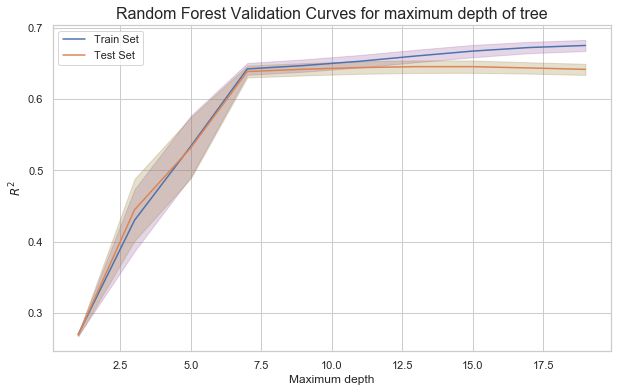

In [17]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, means[0], label = 'train')
axes.fill_between(xs, means[1], means[2], color='#9a5ea1', alpha = 0.25, label='train')
axes.plot(xs, means[3], label = 'validation')
axes.fill_between(xs, means[4], means[5], color='#98823c', alpha = 0.25, label='test')
axes.set_title('Random Forest Validation Curves for maximum depth of tree', fontsize = 16)
axes.legend(['Train Set','Test Set'])
axes.set_xlabel('Maximum depth', fontsize = 12)
axes.set_ylabel('$R^2$', fontsize = 12)
axes.set

plt.show()

Around a Maximum depth of 7, the model seems to fit the data almost perfectly and then it start overfitting. In this case the max_depth of 15 as suggested seems to be a good compromise between bias and variance. I'll keep the max_depth at 15. 

Since n_estimators(number of of trees in the forest) = 10, gave me a similar result compared to recommended model, I'll try validation curves with values between 50-100 and see what I can learn. I know that the default value is 10 and entries for RandomSearchCV were greater than this. I know that the larger the number of trees the more opportunity for the model to learn the data but it also gets more computationally heavy, so let's try values between 20-100 

In [18]:
xs = np.arange(20,100, 20)
train_scores, validation_scores = validation_curve(RandomForestRegressor(max_depth = 15), X = X, y = Y, 
                                                            param_name= 'n_estimators',param_range = xs, cv = 5, scoring = "r2")

In [19]:
means = means_vc(train_scores, validation_scores)

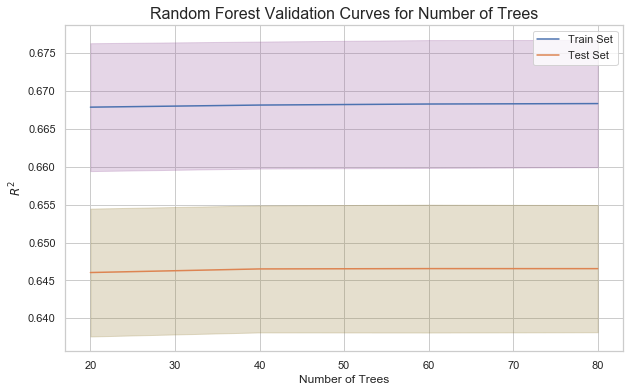

In [20]:
figure = plt.figure(figsize=(14,8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, means[0], label = 'train')
axes.fill_between(xs, means[1], means[2], color='#9a5ea1', alpha = 0.25, label='train')
axes.plot(xs, means[3], label = 'validation')
axes.fill_between(xs, means[4], means[5], color='#98823c', alpha = 0.25, label='test')
axes.set_title('Random Forest Validation Curves for Number of Trees', fontsize = 16)
axes.legend(['Train Set','Test Set'])
axes.set_xlabel('Number of Trees', fontsize = 12)
axes.set_ylabel('$R^2$', fontsize = 12)
axes.set

plt.show()

Doesn't look like it would make much of a difference trying to tune this hyperparameter. So, I am going to leave it at the default which is 10, mainly because it is computationally heavy to have high values for n_estimators. A higher value could be beneficial but I don't have the infrastructure to run this amount.  

Let's try validation curve for min_samples leaf, since the random search yielded 7, let's try higher values

In [21]:
## min_samples_leaf
xs = np.arange(10,30, 5)
train_scores, validation_scores = validation_curve(RandomForestRegressor(max_depth = 15), 
                                                X = X, y = Y, param_name= 'min_samples_leaf',param_range = xs, 
                                                cv = 5, scoring = "r2")


In [22]:
means = means_vc(train_scores, validation_scores)

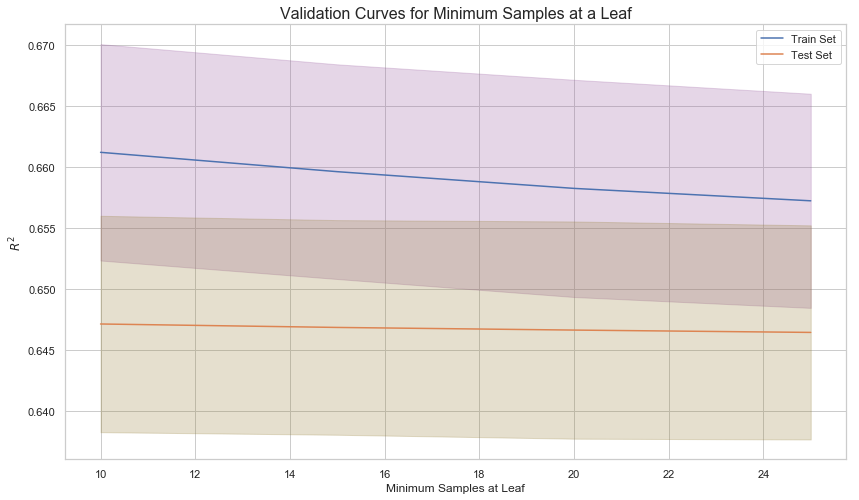

In [23]:
figure = plt.figure(figsize=(14,8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, means[0], label = 'train')
axes.fill_between(xs, means[1], means[2], color='#9a5ea1', alpha = 0.25, label='train')
axes.plot(xs, means[3], label = 'validation')
axes.fill_between(xs, means[4], means[5], color='#98823c', alpha = 0.25, label='test')
axes.set_title('Validation Curves for Minimum Samples at a Leaf', fontsize = 16)
axes.legend(['Train Set','Test Set'])
axes.set_xlabel('Minimum Samples at Leaf', fontsize = 12)
axes.set_ylabel('$R^2$', fontsize =12)
axes.set

plt.show()

This is not very helpful. I'll try percentages of the data to get an idea when the model starts overfitting or underfitting. 

In [24]:
## min_samples_leaf
xs = np.linspace(0.01, 0.50, 10, endpoint=True)
train_scores, validation_scores = validation_curve(RandomForestRegressor(max_depth = 15), X = X, y = Y, 
                                                              param_name= 'min_samples_leaf',param_range = xs, cv = 5, scoring = "r2")


In [25]:
means = means_vc(train_scores, validation_scores)

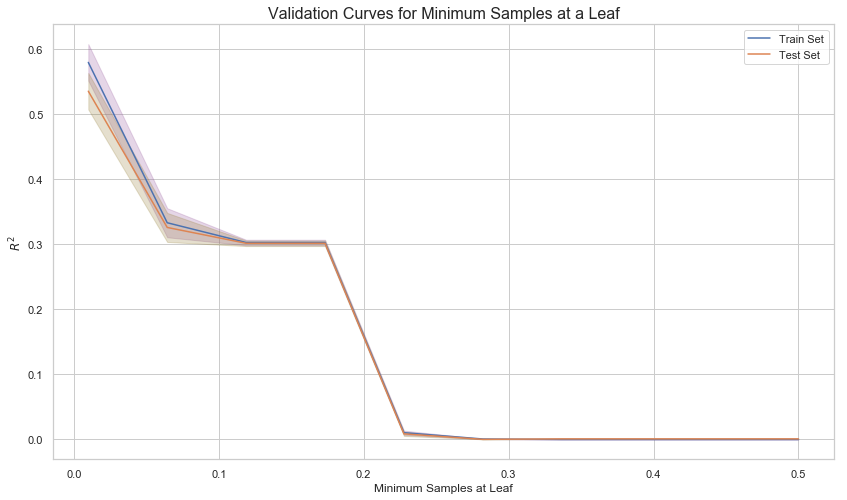

In [26]:
figure = plt.figure(figsize=(14,8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, means[0], label = 'train')
axes.fill_between(xs, means[1], means[2], color='#9a5ea1', alpha = 0.25, label='train')
axes.plot(xs, means[3], label = 'validation')
axes.fill_between(xs, means[4], means[5], color='#98823c', alpha = 0.25, label='test')
axes.set_title('Validation Curves for Minimum Samples at a Leaf', fontsize = 16)
axes.legend(['Train Set','Test Set'])
axes.set_xlabel('Minimum Samples at Leaf', fontsize = 12)
axes.set_ylabel('$R^2$', fontsize = 12)
axes.set

plt.show()

The larger the minimum number of samples to be a leaf node, the worst the model performs and it starts underfitting. Let's try larger values for validation curves and max it to 1000

In [27]:
## min_samples_leaf
xs = np.arange(1, 1100, 100)
train_scores, validation_scores = validation_curve(RandomForestRegressor(max_depth = 15), X = X, y = Y, 
                                                              param_name= 'min_samples_leaf',param_range = xs, cv = 5, scoring = "r2")


In [28]:
means = means_vc(train_scores, validation_scores)

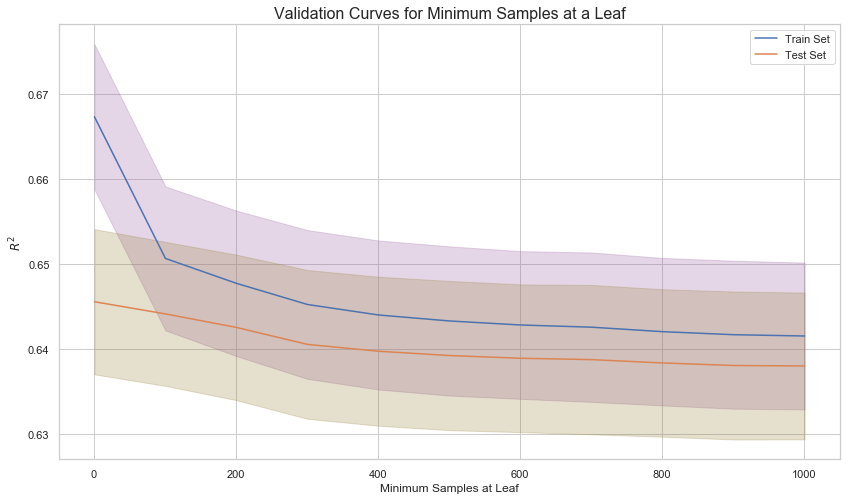

In [29]:
figure = plt.figure(figsize=(14,8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, means[0], label = 'train')
axes.fill_between(xs, means[1], means[2], color='#9a5ea1', alpha = 0.25, label='train')
axes.plot(xs, means[3], label = 'validation')
axes.fill_between(xs, means[4], means[5], color='#98823c', alpha = 0.25, label='test')
axes.set_title('Validation Curves for Minimum Samples at a Leaf', fontsize = 16)
axes.legend(['Train Set','Test Set'])
axes.set_xlabel('Minimum Samples at Leaf', fontsize = 12)
axes.set_ylabel('$R^2$', fontsize =12)
axes.set

plt.show()

From this range of values, it looks like a good compromise in bias and variance would be around 400 even though $R^2$ would be lower. Too small of a value could lead to unprunned trees so I'll go with 400 from now on. 

#### Final hyperparameters 

* Number of trees (n_estimators) = default (10)
* Maximum number of features (max_features) = auto
* Maximum depth(max_depth)= 15
* Minimum samples at leaf (min_samples_leaf) = 400

I am also limiting the fold to 3 and repeating 3 times since anything larger is computational heavy

In [30]:
cv = RepeatedKFold(n_splits = 3, n_repeats=3, random_state=35)
rf = RandomForestRegressor( min_samples_leaf = 400, max_features = 'auto', max_depth = 15, bootstrap =True)
r2_cv = cross_val_score(rf, x_train, y_train, cv=cv, scoring = 'r2')

In [31]:
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=400, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

In [34]:
print('The train r_squared:{:.4f}'.format(np.mean(r2_score(y_train, y_pred_train))))
print('The test r_squared:{:.4f}'.format(np.mean(r2_score(y_test, y_pred_test))))
print('The CV r_squared:{:.4f}'.format(r2_cv.mean()))
print('The test RMSE:{:.2f}'.format(np.mean(np.sqrt(mean_squared_error(y_test, y_pred_test)))))

The train r_squared:0.6433
The test r_squared:0.6458
The CV r_squared:0.6411
The test RMSE:3005.00


The result using 3 repetitions and 3 folds shows improvement on the $R^2$ even though it was a small set of folds and repetitions. 

However, I also see that these values are lower than our base model. 

In [35]:
print("The test r_squared for base model: {:.4f}".format(np.mean(r2_score(y_test, y_pred_test_base))))
print("The test mse for base model: {:.2f}".format(np.mean(np.sqrt(mean_squared_error(y_test, y_pred_test_base)))))

The test r_squared for base model: 0.6505
The test mse for base model: 2984.84


Lets look at the crossvalidation mean results of base model

In [36]:
r2_cv_base = cross_val_score(base_model, x_train, y_train, cv=cv, scoring = 'r2')

In [37]:
print('The CV r_squared of base model:{:.4f}'.format(r2_cv_base.mean()))

The CV r_squared of base model:0.6453


That result is interesting. It is lower than the Cross Validation mean of the final hyperparameters. 
In this case, I'll continue with the final hyperparameters found through validation curves.

Let's look at the feature importance for final model so far

In [38]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Product_Category_1,0.986690
City_Code,0.005303
Occupation,0.003301
Age_Code,0.002119
categories,0.001368
Marital_Status,0.000777
Gender_Code,0.000443


Product Category_1 is the most important, which I expected. I am surprised to see that categories doesn't have larger weight.

I still have Product_ID and User_ID to add. I'll add Product_ID to the model since it seems to be most relevant 

Since Product_ID has a P in front the of value, I need to remove this first.

In [39]:
data["Product_ID"] = data["Product_ID"].astype(str)
data["Product_ID"] = data["Product_ID"].map(lambda x: x.lstrip("P"))

data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,categories,Gender_Code,Age_Code,City_Code
0,1000001,00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370,1,0,0,0
1,1000001,00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,3,0,0,0
2,1000001,00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422,1,0,0,0
3,1000001,00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057,2,0,0,0
4,1000002,00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969,1,1,6,2


That looks good. 

##### Adding Product ID

In [40]:
train, test = train_test_split(data, test_size = 0.2)

x_train = train.drop(['User_ID', 'Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y_train = train['Purchase']

x_test = test.drop(['User_ID', 'Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y_test = test['Purchase']

In [41]:
cv = RepeatedKFold(n_splits = 3, n_repeats=3, random_state=56)
rf2 = RandomForestRegressor( min_samples_leaf = 400, max_depth = 15)
r2_cv2 = cross_val_score(rf2, x_train, y_train, cv=cv, scoring = 'r2')

In [42]:
rf2.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=400, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
y_pred_train2 = rf2.predict(x_train)
y_pred_test2 = rf2.predict(x_test)

In [44]:
print('The train r_squared for the second model:{:.4f}'.format(np.mean(r2_score(y_train, y_pred_train2))))
print('The test r_squared for the second model:{:.4f}'.format(np.mean(r2_score(y_test, y_pred_test2))))
print('The CV r_squared for the second model:{:.4f}'.format(r2_cv2.mean()))
print("The test RMSE for the second model: {:.2f}".format(np.mean(np.sqrt(mean_squared_error(y_test, y_pred_test2)))))

The train r_squared for the second model:0.6893
The test r_squared for the second model:0.6874
The CV r_squared for the second model:0.6796
The test RMSE for the second model: 2806.40


This is great improvement from the first model:

* The train r_squared:0.6433
* The test r_squared:0.6458
* The CV r_squared:0.6411
* The test RMSE:3005.00

The Product_ID feature stays in. As for the importance of features:

In [45]:
feature_importances = pd.DataFrame(rf2.feature_importances_, index = x_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Product_Category_1,0.925568
Product_ID,0.066958
categories,0.003295
City_Code,0.002833
Age_Code,0.000658
Occupation,0.000340
Gender_Code,0.000299
Marital_Status,0.000050


The categories variable has more weight now. Product_Category_1 still seems to be the most important one and the added feature, Product_ID is the second most important.

I was taking the user_id as a personal identifier and at first it didn't seem important but if the company wants to target these users for offers, then maybe I should add this feature. 

In [46]:
train, test = train_test_split(data, test_size = 0.2)

x_train = train.drop(['Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y_train = train['Purchase']

x_test = test.drop(['Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y_test = test['Purchase']

In [47]:
cv = RepeatedKFold(n_splits = 3, n_repeats=3, random_state=39)
rf3 = RandomForestRegressor( min_samples_leaf = 400, max_depth = 15)
r2_cv3 = cross_val_score(rf3, x_train, y_train, cv=cv, scoring = 'r2')

In [48]:
rf3.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=400, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [49]:
y_pred_train3 = rf3.predict(x_train)
y_pred_test3 = rf3.predict(x_test)

In [50]:
print('The train r_squared for the third model:{:.4f}'.format(np.mean(r2_score(y_train, y_pred_train3))))
print('The test r_squared for the third model:{:.4f}'.format(np.mean(r2_score(y_test, y_pred_test3))))
print('The CV r_squared for the third model:{:.4f}'.format(r2_cv3.mean()))
print("The test RMSE for the third model: {:.2f}".format(np.mean(np.sqrt(mean_squared_error(y_test, y_pred_test3)))))

The train r_squared for the third model:0.6888
The test r_squared for the third model:0.6862
The CV r_squared for the third model:0.6794
The test RMSE for the third model: 2815.92


We see slight improvement on the CV $R^2$ but nothing else. The previous results:

* The train r_squared for the second model:0.6893
* The test r_squared for the second model:0.6874
* The CV r_squared for the second model:0.6796
* The test RMSE: 2806.40

Looking at the feature importance, we see:

In [51]:
feature_importances = pd.DataFrame(rf3.feature_importances_, index = x_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Product_Category_1,0.925071
Product_ID,0.067114
categories,0.003298
City_Code,0.002731
Age_Code,0.000612
User_ID,0.000512
Occupation,0.000325
Gender_Code,0.000290
Marital_Status,0.000048


User_Id is not improving the models and clearly is not to one of the top features, so in this case I am going to remove User_ID from the final model and stick with the second model in random forest. 

Let's compare this model to Decision Tree

In [52]:
X = data.drop(['User_ID', 'Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y = data['Purchase']

In [53]:
train, test = train_test_split(data, test_size = 0.2)

x_train = train.drop(['User_ID', 'Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y_train = train['Purchase']

x_test = test.drop(['User_ID', 'Gender', 'Age','City_Category', 'Stay_In_Current_City_Years','Product_Category_2', 'Product_Category_3', 'Purchase'], axis = 1)
y_test = test['Purchase']

In [54]:
xs = np.arange(1,21, 1)
train_scores, validation_scores = validation_curve(DecisionTreeRegressor(), X = X, y = Y, 
                                                            param_name= 'max_depth',param_range = xs, cv = 5, scoring = "r2")

In [55]:
means = means_vc(train_scores, validation_scores)

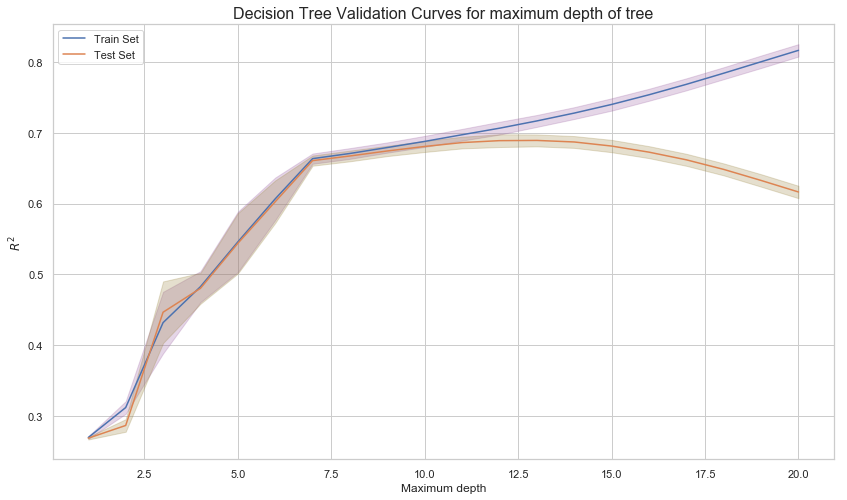

In [56]:
figure = plt.figure(figsize=(14,8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, means[0], label = 'train')
axes.fill_between(xs, means[1], means[2], color='#9a5ea1', alpha = 0.25, label='train')
axes.plot(xs, means[3], label = 'validation')
axes.fill_between(xs, means[4], means[5], color='#98823c', alpha = 0.25, label='test')
axes.set_title('Decision Tree Validation Curves for maximum depth of tree', fontsize = 16)
axes.legend(['Train Set','Test Set'])
axes.set_xlabel('Maximum depth', fontsize = 12)
axes.set_ylabel('$R^2$',fontsize =12)
axes.set

plt.show()

It look like 10 could a good balance between bias and variance.  

It is the same idea for min_samples_leaf for Decision Trees as for Random Forest, so let's look at values between 1 and 500

In [57]:
xs = np.arange(1, 600, 100)
train_scores, validation_scores = validation_curve(DecisionTreeRegressor(max_depth = 10), X = X, y = Y, 
                                                            param_name= 'min_samples_leaf',param_range = xs, cv = 5, scoring = "r2")

In [58]:
means = means_vc(train_scores, validation_scores)

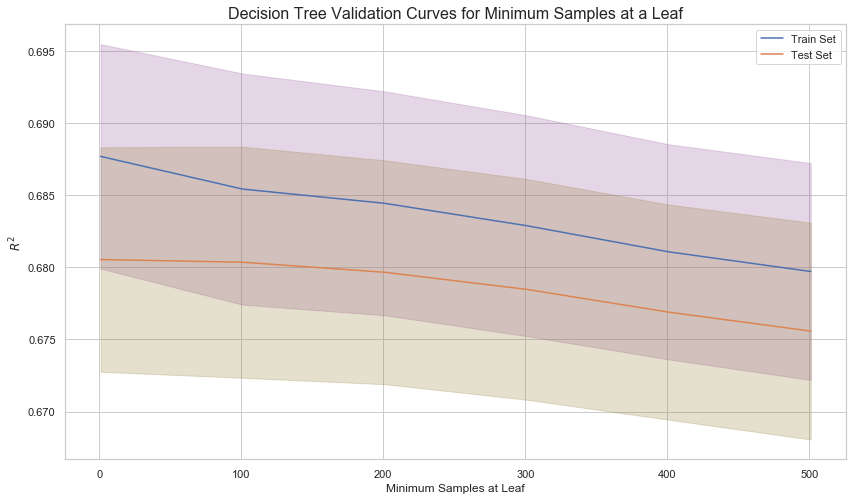

In [59]:
figure = plt.figure(figsize=(14,8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(xs, means[0], label = 'train')
axes.fill_between(xs, means[1], means[2], color='#9a5ea1', alpha = 0.25, label='train')
axes.plot(xs, means[3], label = 'validation')
axes.fill_between(xs, means[4], means[5], color='#98823c', alpha = 0.25, label='test')
axes.set_title('Decision Tree Validation Curves for Minimum Samples at a Leaf', fontsize = 16)
axes.legend(['Train Set','Test Set'])
axes.set_xlabel('Minimum Samples at Leaf', fontsize = 12)
axes.set_ylabel('$R^2$', fontsize = 12)

plt.show()


Very similar results as random forest. Let's keep the same min_samples_leaf as with Random Forest

In [60]:
cv = RepeatedKFold(n_splits = 3, n_repeats=3, random_state=57) #Let's keep the same number of folds and repetitions as with random forest
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=400)
rdt_cv = cross_val_score(dt, x_train, y_train, cv=cv, scoring='r2')

In [61]:
dt.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=400,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [62]:
y_pred_train = dt.predict(x_train)
y_pred_test = dt.predict(x_test)

In [63]:

print('The train r_squared DT:{:.4f}'.format(np.mean(r2_score(y_train, y_pred_train))))
print('The test r_squaredD DT:{:.4f}'.format(np.mean(r2_score(y_test, y_pred_test))))
print('The CV r_squared DT:{:.4f}'.format(rdt_cv.mean()))
print('The test RMSE DT: %f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))

The train r_squared DT:0.6831
The test r_squaredD DT:0.6815
The CV r_squared DT:0.6767
The test RMSE DT: 2832.089620


All values for $R^2$ are lower than for Random Forest and RMSE is higher. The ones from Random Forest:

* The train r_squared for the second model:0.6893
* The test r_squared for the second model:0.6874
* The CV r_squared for the second model:0.6796
* The test RMSE: 2806.40

Let's look at feature importance for decision trees:

In [64]:
feature_importances = pd.DataFrame(dt.feature_importances_, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Product_Category_1,0.930786
Product_ID,0.062057
categories,0.003047
City_Code,0.002849
Age_Code,0.000767
Gender_Code,0.000279
Occupation,0.000197
Marital_Status,0.000018


Reminder of Random Forest:

In [65]:
feature_importances = pd.DataFrame(rf2.feature_importances_, index = x_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Product_Category_1,0.925568
Product_ID,0.066958
categories,0.003295
City_Code,0.002833
Age_Code,0.000658
Occupation,0.000340
Gender_Code,0.000299
Marital_Status,0.000050


The feature importance is almost the same, with the exception that Gender_Code and Marital Status take opposite spots. 

Let's look at the difference in means

In [66]:
def bootstrap_sample( data, f, n=1000):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [67]:
dt_bootstrap = bootstrap_sample(rdt_cv,np.mean)
rf2_bootstrap = bootstrap_sample(r2_cv2,np.mean)
difference = rf2_bootstrap - dt_bootstrap

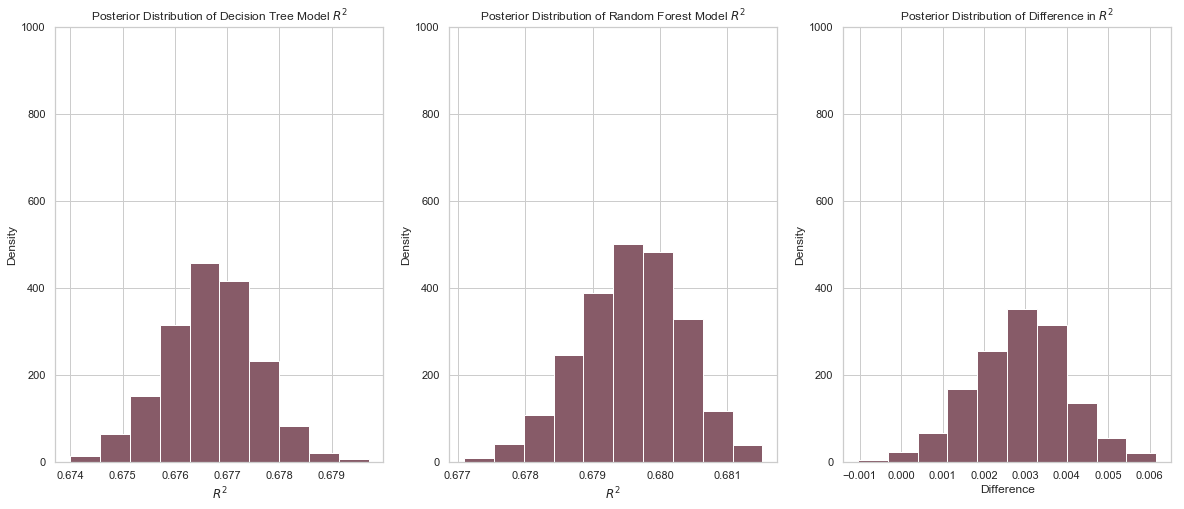

In [68]:
figure = plt.figure(figsize=(20, 8)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(dt_bootstrap, density=True, color = '#875b68')
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_ylim(0,1000)
axes.set_title( "Posterior Distribution of Decision Tree Model $R^2$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(rf2_bootstrap, density=True, color = '#875b68')
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_ylim(0,1000)
axes.set_title( "Posterior Distribution of Random Forest Model $R^2$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True, color = '#875b68')
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_ylim(0,1000)
axes.set_title( "Posterior Distribution of Difference in $R^2$")

plt.show()
plt.close()

In [69]:
ci_rf = stats.mstats.mquantiles(rf2_bootstrap, [0.025, 0.975])
print('The 95% CI for Random Forest:', ci_rf)

The 95% CI for Random Forest: [0.67804127 0.68096383]


In [70]:
ci_dt = stats.mstats.mquantiles(dt_bootstrap, [0.025, 0.975])
print('The 95% CI for Decision Tree:', ci_dt)

The 95% CI for Decision Tree: [0.67491117 0.67837511]


In [71]:
print("Difference in 95% Confidence Interval:", abs(ci_rf - ci_dt))

Difference in 95% Confidence Interval: [0.0031301  0.00258872]


The 95% Credible Interval for the posterior distribution in Random Forest is 0.6780 to 0.6810, while for Decision Trees we see a 95% Credible Interval of 0.6749 to 0.6785 

The difference in Confidence interval is very small, 0.00313 to 0.00259

Let's look at the probability that Random Forest mean $R^2$ is better than the mean $R^2$ for Decision Tree

In [72]:
print("P(Random Forest > Decision Tree)", np.mean(difference >=0))
print("P(Decision Tree > Random Forest)", np.mean(difference <0))

P(Random Forest > Decision Tree) 0.994
P(Decision Tree > Random Forest) 0.006


According to this, there is a 0.6% probability that Decision Tree is better than Random Forest. 

Random Forest does provide better results but this doesn't mean that Decision Trees is not a good fit for the data, especially if further optimization on hyperparameters and more feature engineering is developed. 

Sources:

https://scikit-learn.org/stable/modules/tree.html#tree

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
